In [1]:
import visa                             # Import PyVISA library
import time
from struct import *                    # Import Struct module (interpret strings as packed binary data)
import numpy as np
#import VISAresourceExtentions

In [2]:
# Initialization

rm = visa.ResourceManager()             # Create Resource Manager object
rs = rm.list_resources()                # Method to list the available resources
print(rs[0])                            
counter = rm.open_resource(rs[0])       # Assign the returned object to the instrument variable (i.e. counter)

USB0::5355::145::457158::0::INSTR


In [3]:
# Initial settings

print(counter.query('*IDN?'))           # Query the Identification string 
counter.write('*RST;*CLS')              # Reset the instrument, clear the Error queue
counter.timeout = 1e7                   # Acquisition timeout (ms) - set it higher than the acquisition time
counter.query('SYST:ERR?')              # Error Checking 

PENDULUM, CNT-91, 457158, V1.31 06 Mar 2015 12:55



'0,"No error"\n-'

In [4]:
#Basic settings

counter.write("FUNC 'FREQ:BTB 1'")                      # Setup for frequency back-to-back measurement from channel A (1) - Set up for period back-to-back is "FUNC 'PER:BTB 1'" 
counter.write('CALC:AVER:STAT ON')                      # Enable/disable statitics;
counter.write('INP:LEV:AUTO OFF; :INP:LEV 0')           # Enable/Disable autotrigger on channel A; Trigger level (V)
counter.write('CAL:INT:AUTO OFF; :DISP:ENAB ON')        # Enable/Disable reciprocal counter that uses an interpolating technique to increase the resolution; Enable/Disable the display (if OFF increase the GPIB speed)
counter.query('SYST:ERR?')                              # Error Checking    

'0,"No error"\n-'

In [5]:
#counter.write('*ESE 0;*SRE 0')                      # To be developed
#counter.wait_on_event(counter, RQS, 10000)
#counter.last_status
#counter.query('*ESR?')
#counter.read()
#counter.query('SYST:ERR?')

In [6]:
# Calculate MEAN/MAX/MIN/SDEV/ADEV values (ascii format), only if 'CALC:AVER:STAT ON'

counter.write('CALC:AVER:TYPE MEAN')                                      # Select the statistical function to be performed (MIN/MAX/MEAN/SDEV/ADEV)
counter.write('FORMAT:TINF ON; :FORMAT ASCII')                            # Read timestamp of each measurement ; Redout in ASCII/REAL mode - Redout format: ASCII/REAL -> [freq (Hz), tstamp (sec)]
counter.write('SENSE:ACQ:APER 4e-6; :CALC:AVER:COUNT 1e3')                # Gate time (sec) - (In statistics mode is the Pacing time of the samples), minimum: 4 microsec; Set the number of samples to use in statistics sampling                                      
#time.sleep(1)                                                             # Wait (sec)                                                              

start = time.time()

for i in range(1):
    
    counter.query('INIT;*OPC?')                                           # Initialize acquisition; *OPC? query waits until the acquisition ends

    #counter.write('CALC:DATA?')                                 
    #counter.read()
    #value = counter.query('CALC:DATA?')                                   # Fetch list with string characters as its elements
    #value = counter.query_ascii_values('CALC:DATA?')                      # Fetch ASCII value ( ValueError: 'could not convert string to float can occur' ), sometimes doesn't work when timestamp is printed (i.e. with MIN/MAX )         
    value = counter.query_ascii_values('CALC:DATA?', converter = 's')     # Fetch and Convert ASCII value into a string
    
    value[-1] = value[-1].split('\n')[0]                                  # Delete in the string every character after the number ( i.e. \n0E..)
    value[0] = float(value[0])                                            # Convert string into float number
    value[1] = float(value[1])                                            # Condition necessary when the last element of the list happens to be an empty string = '' 
    #print(value)                                                         # List format -> [value, timestamp]
    
    freqmean = value[0]
    print(freqmean)
    
end = time.time()
print(end-start)                                                           # Total acquisition time (sec)
counter.query('SYST:ERR?')    

38838730.0
0.4893953800201416


'-213,"Init ignored"\n'

In [7]:
# Calculate ADEV for different Gate times

counter.write('CALC:AVER:TYPE ADEV')                                      # Select the statistical function to be performed (MIN/MAX/MEAN/SDEV/ADEV)
counter.write('FORMAT:TINF ON; :FORMAT ASCII')                            # Read timestamp of each measurement ; Redout in ASCII/REAL mode - Redout format: ASCII/REAL -> [freq (Hz), tstamp (sec)]
#time.sleep(1)                                                             # Wait (sec)                                                                

start = time.time()

Taulist = []       # Define list: list=[] ; Define numpy array:  arr=np.array([])
Adevlist = [] 
Sampleslist = []

Samp=[50000, 25000, 16667, 10000, 6250, 4000, 2565, 1588, 1011, 637, 402, 254, 160, 101, 64, 41, 26, 16, 11, 7]    # Define list of samples to take for each gate time

for i in range(4):
    
    x = i-5  # [-5,-4,-3,-2,-1,0,+1]
    
    for y in [0,1,2,3,4]:                                       # Iterations - NotEvenlySpaced: [1,2,4,6,8] - EvenlySpaced: [0,1,2,3,4]
        
        tau = (10**x)*10**(y/5)                                 # Gate time (sec) - NotEvenlySpaced: y*10**(x) - EvenlySpaced: (10**x)*10**(y/5)            
        
        samples = Samp[5*i+y]                                   # Number of Samples:  10**abs(x) - 1000 - ...
        #samples = {x==-1: 100, x==0: 10, x==1: 2}.get(True)     # Instead of if(): ... elif(): ... elif() ... 
        
        #if (x == -5 and y == 2):   break                        # Break the loop when condition is fulfilled
        
        print(f'Gate time = {tau} s, Samples = {samples}')            
    
        counter.write(f'SENSE:ACQ:APER {tau}; :CALC:AVER:COUNT {samples}')    # Set Gate time (sec) and number of Samples 
        counter.query('INIT;*OPC?')                                           # Initialize acquisition; *OPC? query waits until the acquisition ends 
        
        #value = counter.query_ascii_values('CALC:DATA?')                     # Fetch and Convert ASCII value into a string
        value = counter.query_ascii_values('CALC:DATA?', converter = 's')     # Fetch and Convert ASCII value into a string

        value[-1] = value[-1].split('\n')[0]                                  # Delete in the string every character after the number ( i.e. \n0E..)
        value[0] = float(value[0])                                            # Convert string into float number
        value[1] = float(value[1])
        print(value[0])
        
        Taulist.append(tau)                                                   # Append a value to the list at each iteration
        Adevlist.append(value[0])
        Sampleslist.append(samples)
         
        #end = time.time()     
        #print(end-start)                                                      # Acquisition time for each Gate time (sec)

end = time.time()
print(end-start)                                                              # Total acquisition time (sec)
            
counter.query('SYST:ERR?')  

Gate time = 1e-05 s, Samples = 50000
250.0
Gate time = 1.5848931924611138e-05 s, Samples = 25000
260.0
Gate time = 2.5118864315095805e-05 s, Samples = 16667
310.0
Gate time = 3.981071705534973e-05 s, Samples = 10000
393.0
Gate time = 6.309573444801933e-05 s, Samples = 6250
456.0
Gate time = 0.0001 s, Samples = 4000
491.0
Gate time = 0.00015848931924611136 s, Samples = 2565
488.0
Gate time = 0.000251188643150958 s, Samples = 1588
405.0
Gate time = 0.00039810717055349724 s, Samples = 1011
273.3
Gate time = 0.0006309573444801934 s, Samples = 637
159.8
Gate time = 0.001 s, Samples = 402
66.1
Gate time = 0.0015848931924611136 s, Samples = 254
49.0
Gate time = 0.0025118864315095803 s, Samples = 160
21.5
Gate time = 0.0039810717055349725 s, Samples = 101
28.37
Gate time = 0.006309573444801934 s, Samples = 64
18.29
Gate time = 0.01 s, Samples = 41
10.13
Gate time = 0.015848931924611138 s, Samples = 26
5.93
Gate time = 0.0251188643150958 s, Samples = 16
2.95
Gate time = 0.03981071705534972 s, S

'-213,"Init ignored"\n'

In [8]:
print(Taulist)  
print(Adevlist)
print(Sampleslist)

[1e-05, 1.5848931924611138e-05, 2.5118864315095805e-05, 3.981071705534973e-05, 6.309573444801933e-05, 0.0001, 0.00015848931924611136, 0.000251188643150958, 0.00039810717055349724, 0.0006309573444801934, 0.001, 0.0015848931924611136, 0.0025118864315095803, 0.0039810717055349725, 0.006309573444801934, 0.01, 0.015848931924611138, 0.0251188643150958, 0.03981071705534972, 0.06309573444801933]
[250.0, 260.0, 310.0, 393.0, 456.0, 491.0, 488.0, 405.0, 273.3, 159.8, 66.1, 49.0, 21.5, 28.37, 18.29, 10.13, 5.93, 2.95, 4.294, 3.34]
[50000, 25000, 16667, 10000, 6250, 4000, 2565, 1588, 1011, 637, 402, 254, 160, 101, 64, 41, 26, 16, 11, 7]


array([50000, 25000, 16667, 10000,  6250,  4000,  2565,  1588,  1011,
         637,   402,   254,   160,   101,    64,    41,    26,    16,
          11,     7])
array([1.00000000e-05, 1.58489319e-05, 2.51188643e-05, 3.98107171e-05,
       6.30957344e-05, 1.00000000e-04, 1.58489319e-04, 2.51188643e-04,
       3.98107171e-04, 6.30957344e-04, 1.00000000e-03, 1.58489319e-03,
       2.51188643e-03, 3.98107171e-03, 6.30957344e-03, 1.00000000e-02,
       1.58489319e-02, 2.51188643e-02, 3.98107171e-02, 6.30957344e-02])
array([250.   , 260.   , 310.   , 393.   , 456.   , 491.   , 488.   ,
       405.   , 273.3  , 159.8  ,  66.1  ,  49.   ,  21.5  ,  28.37 ,
        18.29 ,  10.13 ,   5.93 ,   2.95 ,   4.294,   3.34 ])
array([6.43687371e-06, 6.69434866e-06, 7.98172340e-06, 1.01187655e-05,
       1.17408576e-05, 1.26420200e-05, 1.25647775e-05, 1.04277354e-05,
       7.03679034e-06, 4.11444967e-06, 1.70190941e-06, 1.26162725e-06,
       5.53571139e-07, 7.30456428e-07, 4.70921680e-07, 2.60822123e-

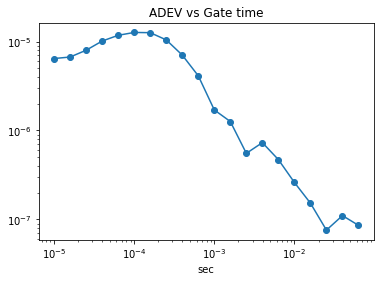

In [10]:
# ADEV vs Gate time plot

import matplotlib.pyplot as plt
import pandas as pd

# Convert lists to numpy arrays

TauArray = np.array(Taulist)      
AdevArray = np.array(Adevlist)
SamplesArray = np.array(Sampleslist)

print(repr(SamplesArray))
print(repr(TauArray))
print(repr(AdevArray))

ADEVArray = AdevArray/freqmean   # Calculate normalized Adev

print(repr(ADEVArray))

plt.plot(TauArray, ADEVArray, 'o-')
plt.xscale('log')
plt.yscale('log')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title('ADEV vs Gate time')
#plt.ylabel('Hz')
plt.xlabel('sec')
plt.show()

In [66]:
#EvenlySpaced

Eadev1=ADEVArray
Etau1=TauArray

In [110]:
Eadev2=ADEVArray

In [171]:
Eadev3=ADEVArray

In [172]:
Eadev4=ADEVArray

In [177]:
Eadev5=ADEVArray

In [71]:
#NotEvenlySpaced

NEadev1=ADEVArray
NEtau1=TauArray

In [75]:
NEadev2=ADEVArray

In [80]:
NEadev3=ADEVArray

In [86]:
NEadev4=ADEVArray

In [159]:
NEadev5=ADEVArray

In [70]:
# Convert [1.4 2.5 6.7] -> [1.4, 2.5, 6.7]
arr = list(map(float, input().split()))
arr = np.array(arr)

In [73]:
print(repr(Etau1))
print(repr(NEtau1))

array([1.58489319e-05, 2.51188643e-05, 3.98107171e-05, 6.30957344e-05,
       1.00000000e-04, 1.58489319e-04, 2.51188643e-04, 3.98107171e-04,
       6.30957344e-04, 1.00000000e-03, 1.58489319e-03, 2.51188643e-03,
       3.98107171e-03, 6.30957344e-03, 1.00000000e-02, 1.58489319e-02,
       2.51188643e-02, 3.98107171e-02, 6.30957344e-02, 1.00000000e-01])
array([1.e-05, 2.e-05, 4.e-05, 6.e-05, 8.e-05, 1.e-04, 2.e-04, 4.e-04,
       6.e-04, 8.e-04, 1.e-03, 2.e-03, 4.e-03, 6.e-03, 8.e-03, 1.e-02,
       2.e-02, 4.e-02, 6.e-02, 8.e-02])


In [74]:
print(repr(Eadev1))
print(repr(Eadev2))
print(repr(Eadev3))
print(repr(Eadev4))
print(repr(Eadev5))

array([6.94980695e-06, 8.23680824e-06, 1.02187902e-05, 1.19433719e-05,
       1.27413127e-05, 1.28700129e-05, 1.08365508e-05, 6.99099099e-06,
       6.61776062e-06, 2.47361647e-06, 1.38738739e-06, 7.38738739e-07,
       7.18661519e-07, 4.61518662e-07, 3.48777349e-07, 1.63191763e-07,
       1.31788932e-07, 8.57657658e-08, 6.65122265e-08, 6.73616474e-08])
array([6.69240669e-06, 8.23680824e-06, 1.00128700e-05, 1.15057915e-05,
       1.25611326e-05, 1.25353925e-05, 1.04247104e-05, 6.96782497e-06,
       4.39639640e-06, 1.74517375e-06, 1.64736165e-06, 1.03732304e-06,
       6.82110682e-07, 4.67696268e-07, 3.55212355e-07, 1.56241956e-07,
       1.22007722e-07, 8.49420849e-08, 6.83655084e-08, 5.59588160e-08])
array([6.94980695e-06, 8.23680824e-06, 1.01930502e-05, 1.19948520e-05,
       1.25868726e-05, 1.28442728e-05, 1.07335907e-05, 7.02960103e-06,
       6.62548263e-06, 2.74388674e-06, 1.65765766e-06, 7.90218790e-07,
       7.16859717e-07, 5.59073359e-07, 3.61904762e-07, 2.02831403e-07,
    

In [75]:
print(repr(NEadev1))
print(repr(NEadev2))
print(repr(NEadev3))
print(repr(NEadev4))
print(repr(NEadev5))

array([5.92020592e-06, 6.94980695e-06, 9.93564994e-06, 1.15830116e-05,
       1.22265122e-05, 1.25096525e-05, 1.19433719e-05, 6.97297297e-06,
       5.42084942e-06, 3.60360360e-06, 2.70785071e-06, 2.07464607e-06,
       5.02445302e-07, 5.79665380e-07, 3.79665380e-07, 3.70913771e-07,
       1.98455598e-07, 8.35778636e-08, 7.68597169e-08, 1.86512227e-07])
array([5.92020592e-06, 6.69240669e-06, 1.01158301e-05, 1.15830116e-05,
       1.22779923e-05, 1.25353925e-05, 1.17117117e-05, 6.97812098e-06,
       5.36679537e-06, 3.82496782e-06, 2.61003861e-06, 2.03861004e-06,
       6.47361647e-07, 3.25353925e-07, 3.44658945e-07, 3.03989704e-07,
       1.84298584e-07, 8.15444015e-08, 6.33976834e-08, 6.26512227e-08])
array([5.92020592e-06, 6.94980695e-06, 1.01415701e-05, 1.17117117e-05,
       1.23552124e-05, 1.25353925e-05, 1.18146718e-05, 6.96525097e-06,
       5.35649936e-06, 2.61261261e-06, 1.71943372e-06, 1.49806950e-06,
       6.24453024e-07, 3.64736165e-07, 3.02960103e-07, 3.27927928e-07,
    

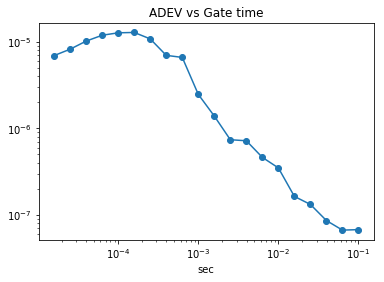

In [70]:
#EvenlySpaced

plt.plot(Etau1, Eadev1, 'o-')
plt.xscale('log')
plt.yscale('log')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title('ADEV vs Gate time')
#plt.ylabel('Hz')
plt.xlabel('sec')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

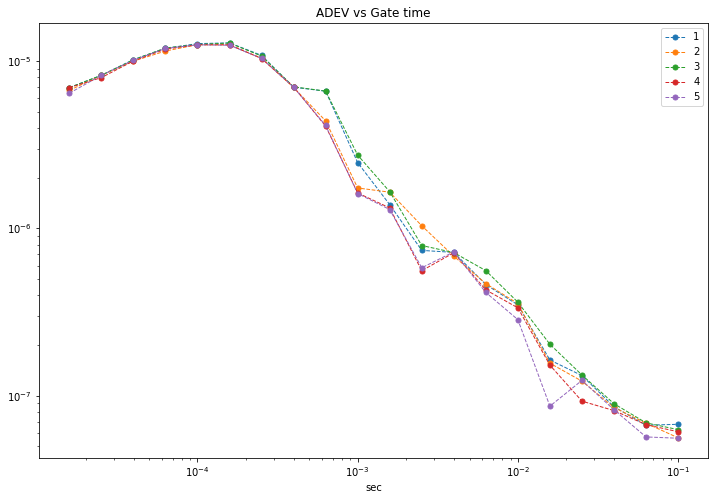

In [113]:
#EvenlySpaced
#Superposed plots

plt.figure(figsize=(12,8))

plt.plot(Etau1, Eadev1, 'o--', linewidth=1, markersize=5, label='1')      #2=3=4 - 5=6=7=8=9 - 
plt.plot(Etau1, Eadev2, 'o--', linewidth=1, markersize=5, label='2')
plt.plot(Etau1, Eadev3, 'o--', linewidth=1, markersize=5, label='3')
plt.plot(Etau1, Eadev4, 'o--', linewidth=1, markersize=5, label='4')
plt.plot(Etau1, Eadev5, 'o--', linewidth=1, markersize=5, label='5')


plt.xscale('log')
plt.yscale('log')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title('ADEV vs Gate time')
#plt.ylabel('Hz')
plt.xlabel('sec')
plt.legend()
plt.show()

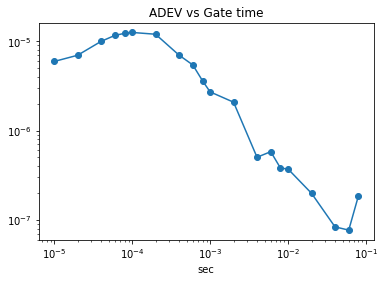

In [72]:
#NotEvenlySpaced

plt.plot(NEtau1, NEadev1, 'o-')
plt.xscale('log')
plt.yscale('log')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title('ADEV vs Gate time')
#plt.ylabel('Hz')
plt.xlabel('sec')
plt.show()

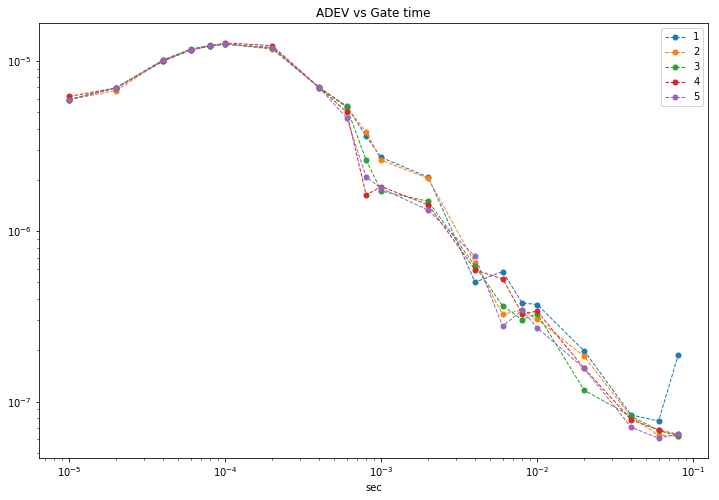

In [112]:
#NotEvenlySpaced
#Superposed plots

plt.figure(figsize=(12,8))

plt.plot(NEtau1, NEadev1, 'o--', linewidth=1, markersize=5, label='1')
plt.plot(NEtau1, NEadev2, 'o--', linewidth=1, markersize=5, label='2')
plt.plot(NEtau1, NEadev3, 'o--', linewidth=1, markersize=5, label='3')
plt.plot(NEtau1, NEadev4, 'o--', linewidth=1, markersize=5, label='4')
plt.plot(NEtau1, NEadev5, 'o--', linewidth=1, markersize=5, label='5')

plt.xscale('log')
plt.yscale('log')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title('ADEV vs Gate time')
#plt.ylabel('Hz')
plt.xlabel('sec')
plt.legend()
plt.show()

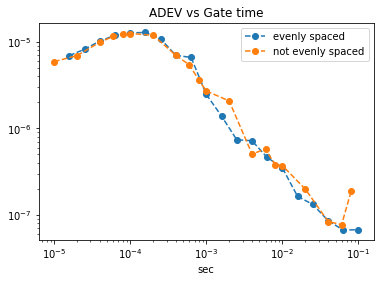

In [73]:
#Superposed plots
#EvenlySpaced vs Not EvenlySpaced

plt.plot(Etau1, Eadev1, 'o--', label='evenly spaced')
plt.plot(NEtau1, NEadev1, 'o--', label='not evenly spaced')
plt.xscale('log')
plt.yscale('log')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title('ADEV vs Gate time')
#plt.ylabel('Hz')
plt.xlabel('sec')
plt.legend()
plt.show()

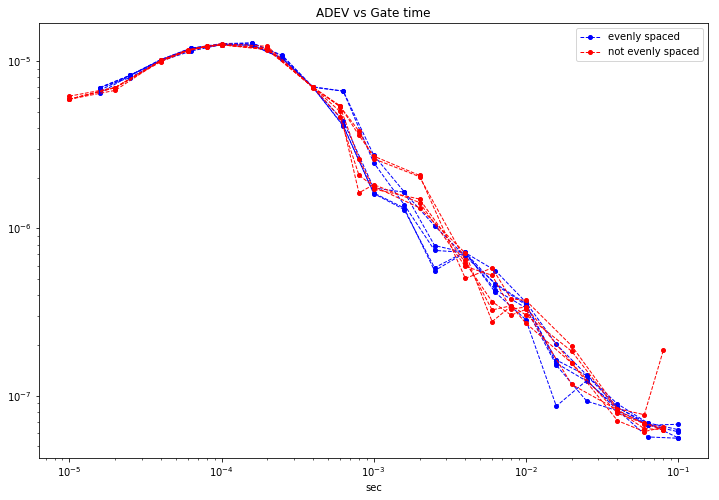

In [114]:
#Superposed plots
#EvenlySpaced vs Not EvenlySpaced

plt.figure(figsize=(12,8))

plt.plot(Etau1, Eadev1, 'o--', linewidth=1, markersize=4, label='evenly spaced', color='b')
plt.plot(Etau1, Eadev2, 'o--', linewidth=1, markersize=4, color='b')
plt.plot(Etau1, Eadev3, 'o--', linewidth=1, markersize=4, color='b')
plt.plot(Etau1, Eadev4, 'o--', linewidth=1, markersize=4, color='b')
plt.plot(Etau1, Eadev5, 'o--', linewidth=1, markersize=4, color='b')
plt.plot(NEtau1, NEadev1, 'o--', linewidth=1, markersize=4, label='not evenly spaced', color='r')
plt.plot(NEtau1, NEadev2, 'o--', linewidth=1, markersize=4, color='r')
plt.plot(NEtau1, NEadev3, 'o--', linewidth=1, markersize=4, color='r')
plt.plot(NEtau1, NEadev4, 'o--', linewidth=1, markersize=4, color='r')
plt.plot(NEtau1, NEadev5, 'o--', linewidth=1, markersize=4, color='r')
plt.xscale('log')
plt.yscale('log')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title('ADEV vs Gate time')
#plt.ylabel('Hz')
plt.xlabel('sec')
plt.legend()
plt.show()